# FasterRCNN Quickstart

## Imports

Mantisshrimp is built in such a way that is safe to use wildcard imports,
.e.g. `from mantisshrimp import *`.

`from mantisshrimp.imports import *` will import commonly used packages like `np` and `plt`.

`from mantisshrimp import *` will import all mantis modules needed for development.

In [1]:
from mantisshrimp.imports import *
from mantisshrimp import *
import pandas as pd
import albumentations as A

/home/lgvaz/anaconda3/envs/light2/lib/python3.7/site-packages/graphql/type/directives.py:55: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  assert isinstance(locations, collections.Iterable), 'Must provide locations for directive.'
/home/lgvaz/anaconda3/envs/light2/lib/python3.7/site-packages/trains/backend_interface/metrics/events.py:27: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.attrs(cmp=False, slots=True)


## Parser

The first step is to understand the data. In this task we were given a `.csv` file with annotations, let's take a look at that.

<div class="alert alert-info">
    
**Note:**  

Replace `source` with your own path for the dataset directory.
    
</div>

In [2]:
source = Path("/home/lgvaz/.data/wheat")
df = pd.read_csv(source / "train.csv")
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


At first glance, we can make the following assumptions:  
* Multiple rows with the same object_id, width, height  
* A different bbox for each row  
* source doesn't seem relevant right now  

Once we know what our data provides we can create our custom `Parser`.  

When creating a `Parser` we inherit from smaller building blocks that provides the functionallity we want:  
* `DefaultImageInfoParser`: Will parse standard fields for image information, e.g. `filepath`, `height`, `width`  
* `FasterRCNNParser`: Since we only need to predict bboxes we will use a `FasterRCNN` model, this will parse all the requirements for using such a model.  

We can also specify exactly what fields we would like to parse, in fact, the parsers we are currently using are just helper classes that groups a collection of individual parsers.  
We are going to see how to use individual parsers in a future tutorial.

<div class="alert alert-info">
    
**Note:**

If you are using an IDE there is a little bit of magic than can happen. Once you created defined your class you can right click on it and select the option _"implement abstract methods"_, this will automatically populate your class with all the methods you need to override. 

If you are using a notebook, or your IDE does not support that, check the documentation to know what methods you should override.

</div>


<div class="alert alert-warning">
    
**Important:**  
    
Be sure to return the correct type on all overriden methods!
    
</div>

In [3]:
class WheatParser(DefaultImageInfoParser, FasterRCNNParser):
    def __init__(self, df, source):
        self.df = df
        self.source = source
        self.imageid_map = IDMap()

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> int:
        return self.imageid_map[o.image_id]

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}.jpg"

    def height(self, o) -> int:
        return o.height

    def width(self, o) -> int:
        return o.width

    def label(self, o) -> List[int]:
        return [1]

    def bbox(self, o) -> List[BBox]:
        return [BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=","))]

Defining the `__init__` is completely up to you, normally we have to pass our data (the `df` in our case) and the folder where our images are contained (`source` in our case).

We then override `__iter__`, telling our parser how to iterate over our data. In our case we call `df.itertuples` to iterate over all `df` rows.

`__len__` is not obligatory but will help visualizing the progress when parsing.

And finally we override all the other methods, they all receive a single argument `o`, which is the object returned by `__iter__`.

Now we just need to decide how to split our data and `Parser.parse`!

In [4]:
data_splitter = RandomSplitter([.8, .2])
parser = WheatParser(df, source / "train")
train_records, valid_records = parser.parse(data_splitter)

Let's take a look at one record.

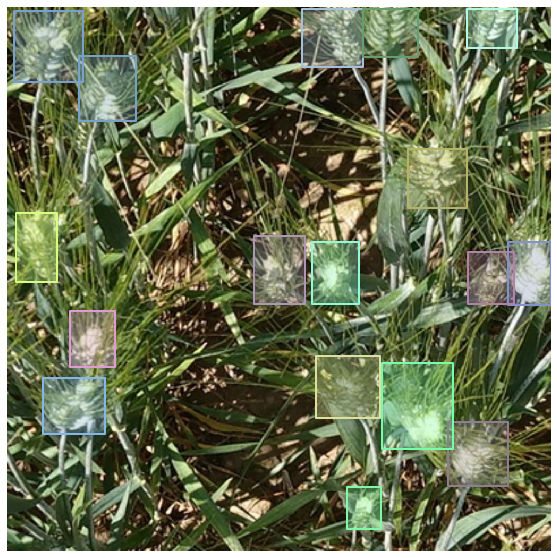

In [5]:
show_record(train_records[0], label=False)

## Transforms and Datasets

Mantisshrimp is agnostic to the transform library you want to use. We provide default support for [albumentations](https://github.com/albumentations-team/albumentations) but if you want to use another library you just need to inherit and override all abstract methods of `Transform`.

For simplicity, let's use a single transform on the train data and no transforms on the validation data.

In [6]:
train_tfm = AlbuTransform([A.Flip()])

For creating a `Dataset` we just need need to pass the parsed records from the previous step and optionally a transform.

In [7]:
train_dataset = Dataset(train_records, train_tfm)
valid_dataset = Dataset(valid_records)

## Model

For this task we are going to use the `FasterRCNN` model (we would use `MaskRCNN` if we also needed to predict masks).  
For creating the model, we just need to pass the number of classes our dataset has, for this task it's 2 (wheat and background).

In [8]:
model = MantisFasterRCNN(num_classes=2)

## DataLoader

All mantis models have a `dataloader` method that returns a customized `DataLoader`.

In [9]:
train_dataloader = model.dataloader(train_dataset, shuffle=True, batch_size=4)
valid_dataloader = model.dataloader(valid_dataset, batch_size=4)

## Metrics

Perhaps the most useful metric in object detection is the one used in the COCO competetion, so let's use that!

In [10]:
metrics = []
metrics += [COCOMetric(valid_records, bbox=True, mask=False, keypoint=False)]


creating index...
index created!


## Training

Mantisshrimp is agnostic to the training engine, meanining you can use your favorite library for training the model.  

We currently support [fastai2](https://github.com/fastai/fastai2) and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) out of the box, meaning that we have helper functions to ease out the connection. But this does not mean you cannot use other libraries, it just means you might have to write some more code.

### fastai

For getting access to the helper functions to train with fastai, just `import` as follows:

In [11]:
from mantisshrimp.engines.fastai import *

Just create a `Learner` like you would do in `fastai` and train your model!  

In [12]:
learn = rcnn_learner(dls=[train_dataloader, valid_dataloader], model=model, metrics=metrics)

/home/lgvaz/git/fastai2/fastai2/callback/core.py:29: UserWarning: You are setting an attribute (loss) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.loss` if you would like to change it in the learner.
  warn(f"You are setting an attribute ({name}) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.{name}` if you would like to change it in the learner.")


In [ ]:
learn.fine_tune(3, lr=2e-4)

epoch,train_loss,valid_loss,COCOMetric,time


/home/lgvaz/anaconda3/envs/light2/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


### pytorch-lightning

Same as we did with fastai, for getting access to the helper functions to train with lightning execute the imports:

In [11]:
from mantisshrimp.engines.lightning import *

Inherit from `RCNNLightningAdapter` and implement the method `configure_optimizers`.  

In [12]:
class LightModel(RCNNLightningAdapter):
    def configure_optimizers(self):
        opt = SGD(self.parameters(), 2e-4, momentum=0.9)
        return opt

<div class="alert alert-info">
    
**Note:**
    
If you are used with lightning, you may be wondering what happened with `training_step`, `validation_step` and methods that we normally have to override while using lightning. What happens is that under the hood `RCNNLightningAdapter` is already implement those methods for you (with the additional bennefit of supporting `Metric`s.  

If you need more custom functionality, don't be afraid of reimplementing those methods, there is no magic happening under the hood, all lightning!  
    
</div>

Now, just creat your lightning model by to it the model we created before and the metric you want to use.

In [16]:
light_model = LightModel(model, metrics=metrics)

In [18]:
trainer = Trainer(max_epochs=3, gpus=1)
trainer.fit(light_model, train_dataloader, valid_dataloader)